In [47]:
import numpy as np
import matplotlib.pyplot as plt
import fenics
from scipy.stats import norm

## **Exercise 2 (Verifying the theory of Gaussian processes with Monte Carlo)**

Let $\Omega \subset \mathbb{R}^d$ be a bounded domain and let $G$ be a centered Gaussian process, defined over $\Omega$, with covariance kernel $K = K(\mathbf{x}, \mathbf{x'})$. Define  

$$\sigma^2 := \max_{\mathbf{x} \in \Omega} K(\mathbf{x}, \mathbf{x'}).$$  

The **Borell-TIS** inequality states that  

$$\mathbb{P} \left( \|G\|_{\infty} > z + \mathbb{E} \|G\|_{\infty} \right) \leq \exp \left( \frac{-z^2}{2\sigma^2} \right),$$  

where $\|G\|_{\infty} := \sup_{\mathbf{x} \in \Omega} |G(\mathbf{x})|$ is the scalar-valued random variable corresponding to the maximum value of $G$ over the spatial domain (in modulus). Starting from the previous, one can easily prove that  

$$\mathbb{E} \|G\|_{\infty} \leq \sqrt{2\pi} \sigma.$$  


Let us now consider a practical example where $\Omega = (0,1)^2$ is the unit square. In what follows, you may rely on a Finite Element discretization to implement the code (cf. Lab 4). Specifically, you are suggested discretizing the spatial domain with a structured triangular mesh of stepsize $h = \sqrt{2}/30$ (that is, by splitting each edge of the square into 30 intervals of equal length).  

### a) Auxiliary code for Finite Element simulation from Lab 4

In [2]:
# Auxiliary functions used to differentiate code behavior between
# problems with d = 1 and d > 1

def P1space(mesh):
  """Creates a FunctionSpace object associated to P1 finite elements on the given mesh.
  Input 'mesh' should be either a numpy array (for 1D problems) or a dolfin.cpp.Mesh object (higher dimensions)."""
  from fenics import FunctionSpace, IntervalMesh
  from IPython.display import clear_output

  # d = 1
  try:
    if(np.diff(mesh).var()>1e-14):
      raise RuntimeError("1D mesh is not uniform. For 1D problems, please ensure a uniform stepsize.")
    V = FunctionSpace(IntervalMesh(len(mesh)-1, mesh[0], mesh[-1]), 'CG', 1)

  # d > 1
  except:
    V = FunctionSpace(mesh, 'CG', 1)

  clear_output()
  return V

def coordinates(mesh):
  """Coordinates of the vertices in a given mesh, returned as a Nh x d array
  (Nh = number of dof, d = space dimension)."""
  try:
    return mesh.coordinates()
  except:
    return mesh.reshape(-1, 1)

In [3]:
def assembleM(mesh):
  """Assembles the L2 mass matrix for P1 elements on a given mesh. Returns an Nh x Nh matrix.
  Matrix action is encoded following the same dofs ordering used in __main__.coordinates."""
  from fenics import assemble, dx, TrialFunction, TestFunction
  from fenics import vertex_to_dof_map
  from IPython.display import clear_output

  V = P1space(mesh)
  u, v = TrialFunction(V), TestFunction(V) # symbols
  M = assemble(u*v*dx).array()             # bilinear form is assembled and converted to array
  perm = vertex_to_dof_map(V)              # re-sorting to ensure compatibility with mesh ordering
  M = M[perm]
  M = M[:, perm]
  clear_output()
  return M

def assembleK(k, mesh):
  import inspect
  if(len(inspect.signature(k).parameters)!=1):
    raise RuntimeError("This function accepts isotropic kernels only (k should be a function of a single argument).")

  vertices = coordinates(mesh)             # Nh x d array listing all vertices
  dim = vertices.shape[1]                  # spatial dimension

  # Constructing the matrix C with Cij = k(|x_i-x_j|)
  d = np.linalg.norm(vertices.reshape(-1, 1, dim) - vertices.reshape(1, -1, dim), axis = -1)
  C = k(d)

  # Adjusting to include quadrature rules (K is an integral operator!)
  M = assembleM(mesh)
  K = C @ M
  return K

In [5]:
def KKLdecomposition(kernel, mesh):
  from scipy.linalg import eigh
  K = assembleK(kernel, mesh)
  M = assembleM(mesh)

  lambdas, psis = eigh(M @ K, M)      # solving eigenvalue problem with M-orthogonality
  lambdas = np.flip(lambdas)      # re-sorting in descending order
  psis = np.flip(psis, axis = -1) # same

  nmax = sum(lambdas>0) # negative values may appear due to floating point errors
  lambdas = lambdas[:nmax]
  psis = psis[:, :nmax]
  return lambdas, psis, M

### b) Sample from Gaussian Process

Let $K(\mathbf{x}, \mathbf{x'}) = e^{-10\|\mathbf{x} - \mathbf{x'}\|^2}$, so that $\sigma^2 = 1$. Sample $N = 1000$ independent random realizations of the Gaussian process $G$. 

In [10]:
from fenics import UnitSquareMesh
mesh = UnitSquareMesh(30, 30)
kernel = lambda r: np.exp(-10*r**2)
K = assembleK(kernel, mesh)
M = assembleM(mesh)
lambdas, psis, M = KKLdecomposition(kernel, mesh)

In [11]:
import matplotlib.tri as tri
vertices = mesh.coordinates()
triangles = mesh.cells()
triangulation = tri.Triangulation(*vertices.T, triangles)

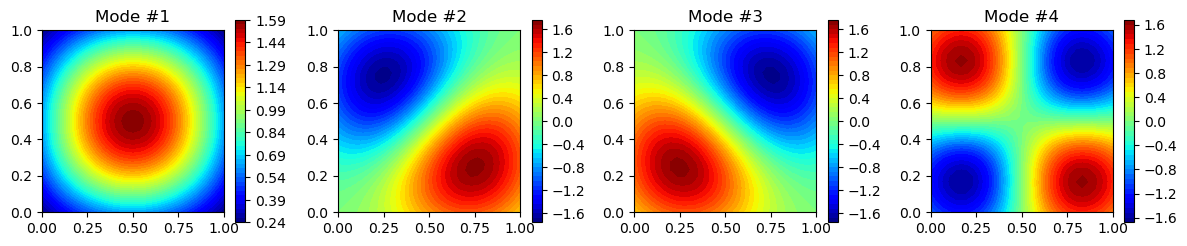

In [12]:
plt.figure(figsize = (12, 3))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.tricontourf(triangulation, psis[:, i], cmap='jet', levels = 50)
  plt.colorbar(shrink = 0.75)
  plt.gca().set_aspect('equal')
  plt.title("Mode #%d" % (i+1))

plt.tight_layout()

In [17]:
def KKLcombine(xis, lambdas_kkl, psis_kkl):
  eigs_scaling = np.sqrt(lambdas_kkl.reshape(-1, 1))
  coefficients = eigs_scaling*xis
  return psis_kkl @ coefficients

In [18]:
mesh = UnitSquareMesh(30, 30)
kernel = lambda r: np.exp(-10*r**2)
lambdas, psis, M = KKLdecomposition(kernel, mesh)

In [117]:
N = 1000
np.random.seed(1)
xis = np.random.randn(len(lambdas), N)
Z = KKLcombine(xis, lambdas, psis)

In [21]:
Z.shape

(961, 1000)

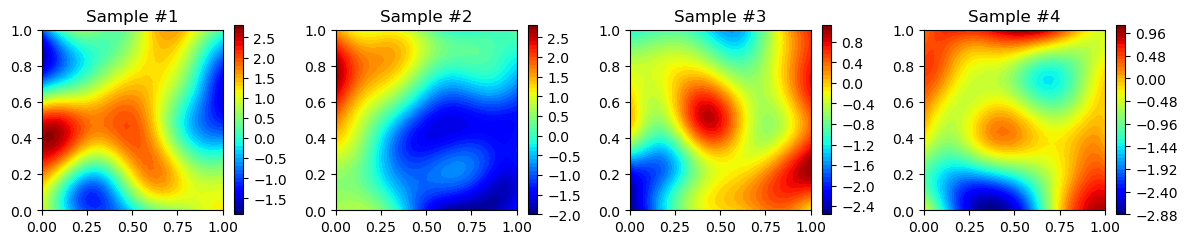

In [20]:
vertices = mesh.coordinates()
triangles = mesh.cells()
triangulation = tri.Triangulation(*vertices.T, triangles)

plt.figure(figsize = (12, 3))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.tricontourf(triangulation, Z[:, i], cmap='jet', levels = 50)
  plt.colorbar(shrink = 0.7)
  plt.gca().set_aspect('equal')
  plt.title("Sample #%d" % (i+1))

plt.tight_layout()

### c) Estimating the Expected Supreme Norm of G Using Random Sampling 
For each of those, compute $X = \|G\|_{\infty}$. Use the latter random sample to derive a pointwise estimate for $\mathbb{E}[X]$.

In [118]:
X = np.max(np.abs(Z), axis=0)

In [119]:
mu = np.mean(X)
sigma_x = np.var(X, ddof=1)
#sigma = 1
mu, sigma_x

(2.3609675411213593, 0.26455256074852446)

### d) Compute an Unilateral Confidence Interval
Enrich your estimate at point (1.) by computing an unilateral confidence interval of the form $(- \infty, a]$. Set the level of confidence to $\epsilon = 95 \%$. Is your result consistent with the (2.2) inequality?

In [120]:
alpha = 0.05
z = norm.ppf(1.0-alpha)

ci_sup = mu + z*np.sqrt(sigma_x/N)
ci_inf = -np.inf
ci_sup

2.3877212034687343

In [121]:
sigma = 1
bound = np.sqrt(2*np.pi*sigma)
ci_sup, bound

(2.3877212034687343, 2.5066282746310002)

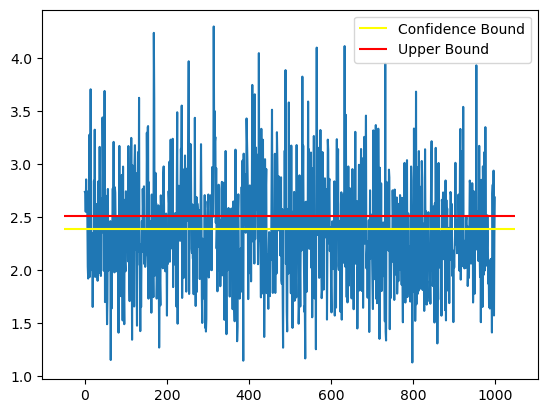

In [110]:
plt.plot(X)
xmin, xmax = plt.xlim()
plt.hlines(ci_sup, xmin=xmin, xmax=xmax, color='yellow', label="Confidence Bound")
plt.hlines(bound, xmin=xmin, xmax=xmax, color='red', label="Upper Bound")
plt.legend()
plt.show()

In [ ]:
nrepeats = 100
count = []

for i in range(nrepeats):
    N = 1000
    xis = np.random.randn(len(lambdas), N)
    Z = KKLcombine(xis, lambdas, psis)
    ci_sup = mu + z*sigma/np.sqrt(N)
    bound = np.sqrt(2*np.pi)
    
    count.append(ci_sup<bound)
    print(ci_sup<bound)

In [74]:
np.sum(count)

100

### e) Improve the estimate using Control Variates
Try improving your estimate by using the method of *control variates*. Specifically, notice that if  

$$
Q := \int_{\Omega} |G(\mathbf{x})|^2 d\mathbf{x} \quad \text{then} \quad \mathbb{E}[Q] = \sum_{i=1}^{\infty} \lambda_i,
$$  

where $\lambda_1 \geq \lambda_2 \geq \dots \geq 0$ are the eigenvalues appearing in the Kosambi-Karhunen-Loève expansion of $G$. In light of this, use $Q$ as a control variate to improve the estimate at points (a)-(b). To ensure a fair comparison, use $n_0 = 30$ samples to estimate the control coefficient and $n_1 = N - n_0$ samples to estimate $\mathbb{E}[X]$.  

In [122]:
def cvariates_sample(N):
    #compute c* optimal control parameter using n0 coeff
    n0 = 30
    np.random.seed(1)
    xis = np.random.randn(len(lambdas), n0)
    Z = KKLcombine(xis, lambdas, psis)
    X = np.max(np.abs(Z), axis=0)
    Q = np.zeros(n0)
    for i in range(n0): 
        Q[i] = Z[:,i].T @ M @ Z[:,i]

    covs = np.cov(X, Q)
    c = -covs[0,1]/covs[1,1] 
    
    # Sample X
    n1 = N - n0
    np.random.seed(1)
    xis = np.random.randn(len(lambdas), n1)
    Z = KKLcombine(xis, lambdas, psis)
    X = np.max(np.abs(Z), axis=0) 
    Q = np.zeros(n1)
    for i in range(n1): 
        Q[i] = Z[:,i].T @ M @ Z[:,i]

    #compute E[Q]
    EQ = np.mean(Q, axis=0)


    # Compute Xc
    Xcv = X + c*(Q-EQ)
    
    return Xcv

In [123]:
Xcv = cvariates_sample(N)
alpha = 0.05
z = norm.ppf(1.0-alpha)
sigma_xcv = np.var(Xcv, ddof=1)

ci_sup = mu + np.sqrt(z*sigma_xvc/N)
Xcv.mean(),  z*np.sqrt(sigma_xvc/N), sigma_xcv

(2.3736619022996437, 0.017404752825620397, 0.11913440760965659)

In [124]:
sigma_x, sigma_xcv

(0.26455256074852446, 0.11913440760965659)

### f) Repeat the procedures using a different Kernel
Repeat points (a)-(b)-(c) with $K(\mathbf{x}, \mathbf{x'}) = e^{-\|\mathbf{x} - \mathbf{x'}\|}$.

In [125]:
def KKLcombine(xis, lambdas_kkl, psis_kkl):
  eigs_scaling = np.sqrt(lambdas_kkl.reshape(-1, 1))
  coefficients = eigs_scaling*xis
  return psis_kkl @ coefficients

In [126]:
mesh = UnitSquareMesh(30, 30)
kernel = lambda r: np.exp(-r**2)
lambdas, psis, M = KKLdecomposition(kernel, mesh)

In [127]:
N = 1000
np.random.seed(1)
xis = np.random.randn(len(lambdas), N)
Z = KKLcombine(xis, lambdas, psis)

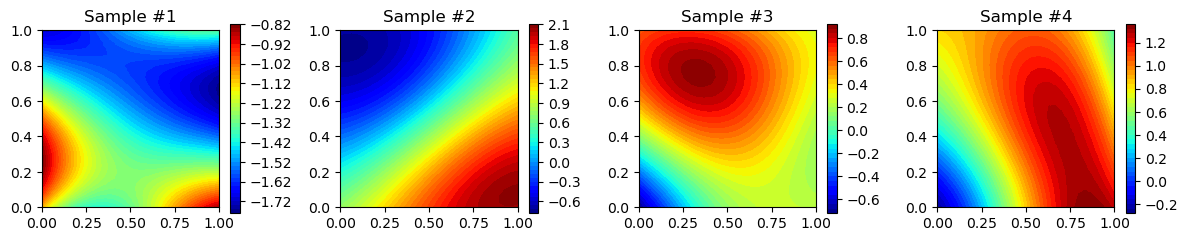

In [128]:
vertices = mesh.coordinates()
triangles = mesh.cells()
triangulation = tri.Triangulation(*vertices.T, triangles)

plt.figure(figsize = (12, 3))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.tricontourf(triangulation, Z[:, i], cmap='jet', levels = 50)
  plt.colorbar(shrink = 0.7)
  plt.gca().set_aspect('equal')
  plt.title("Sample #%d" % (i+1))

plt.tight_layout()

In [129]:
X = np.max(np.abs(Z), axis=0)

In [130]:
mu = np.mean(X)
sigma_x = np.var(X, ddof=1)
#sigma = 1
mu, sigma_x

(1.5762644772421894, 0.3535310763717108)

In [131]:
alpha = 0.05
z = norm.ppf(1.0-alpha)

ci_sup = mu + z*np.sqrt(sigma_x/N)
ci_inf = -np.inf
ci_sup

1.6071917094089512

In [132]:
sigma = 1
bound = np.sqrt(2*np.pi*sigma)
ci_sup, bound

(1.6071917094089512, 2.5066282746310002)

In [133]:
def cvariates_sample(N):
    #compute c* optimal control parameter using n0 coeff
    n0 = 30
    np.random.seed(1)
    xis = np.random.randn(len(lambdas), n0)
    Z = KKLcombine(xis, lambdas, psis)
    X = np.max(np.abs(Z), axis=0)
    Q = np.zeros(n0)
    for i in range(n0): 
        Q[i] = Z[:,i].T @ M @ Z[:,i]

    covs = np.cov(X, Q)
    c = -covs[0,1]/covs[1,1] 
    
    # Sample X
    n1 = N - n0
    np.random.seed(1)
    xis = np.random.randn(len(lambdas), n1)
    Z = KKLcombine(xis, lambdas, psis)
    X = np.max(np.abs(Z), axis=0) 
    Q = np.zeros(n1)
    for i in range(n1): 
        Q[i] = Z[:,i].T @ M @ Z[:,i]

    #compute E[Q]
    EQ = np.mean(Q, axis=0)


    # Compute Xc
    Xcv = X + c*(Q-EQ)
    
    return Xcv

In [134]:
Xcv = cvariates_sample(N)
alpha = 0.05
z = norm.ppf(1.0-alpha)
sigma_xcv = np.var(Xcv, ddof=1)

ci_sup = mu + np.sqrt(z*sigma_xvc/N)
Xcv.mean(),  z*np.sqrt(sigma_xvc/N), sigma_xcv

(1.5818986329328295, 0.017404752825620397, 0.12750927773900617)

In [135]:
sigma_x, sigma_xcv

(0.3535310763717108, 0.12750927773900617)